In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from mitgcmdata import MITgcmmodel
from jmd95 import eos
import xray
import xgcm

%matplotlib inline
plt.rcParams['image.origin'] = 'bottom'
plt.rcParams['figure.figsize'] = (16,8)


In [2]:
ddir = '/data/scratch/rpa/SOSE/run_np240'

iters = range(480, 210240, 480)
#iters = range(48,120720+1,96)
ds = xray.decode_cf(xgcm.open_mdsdataset(ddir, iters, prefix=['DiagIceNew-5day'], #prefix=['TSUVWP_1d',],
                             deltaT=900, ref_date='2005-01-01 00:00:00', calendar='gregorian'))
ds

/home/rpa/xgcm/xgcm/mdsxray.py:259: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


<xray.Dataset>
Dimensions:               (X: 2160, Xp1: 2160, Y: 320, Yp1: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, layers1RHO_bounds: 70, layers1RHO_center: 69, layers1RHO_interface: 68, time: 437)
Coordinates:
    YC                    (Y, X) float32 -77.875 -77.875 -77.875 -77.875 ...
    YG                    (Yp1, Xp1) float32 -77.9583 -77.9583 -77.9583 ...
    rA                    (Y, X) float32 7.21182e+07 7.21182e+07 7.21182e+07 ...
  * Xp1                   (Xp1) float32 5.55112e-17 0.166667 0.333333 0.5 ...
    PHrefC                (Z) float32 49.05 152.055 264.87 387.495 519.93 ...
    PHrefF                (Zp1) float32 0.0 98.1 206.01 323.73 451.26 588.6 ...
    dxG                   (Yp1, X) float32 3865.71 3865.71 3865.71 3865.71 ...
    dxC                   (Y, Xp1) float32 3892.06 3892.06 3892.06 3892.06 ...
  * Zl                    (Zl) float32 0.0 -10.0 -21.0 -33.0 -46.0 -60.0 ...
  * Yp1                   (Yp1) float32 -77.9583 -77.7916 -77.625 -77.4583 ...
  * Zp1 

In [4]:
ds['SIuheff_shift'] = xray.DataArray(ds.SIuheff.data, dims=ds.SIarea.dims, coords=ds.SIarea.coords)
ds['SIvheff_shift'] = xray.DataArray(ds.SIvheff.data, dims=ds.SIarea.dims, coords=ds.SIarea.coords)

In [5]:
ds

<xray.Dataset>
Dimensions:               (X: 2160, Xp1: 2160, Y: 320, Yp1: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, layers1RHO_bounds: 70, layers1RHO_center: 69, layers1RHO_interface: 68, time: 437)
Coordinates:
    YC                    (Y, X) float32 -77.875 -77.875 -77.875 -77.875 ...
    YG                    (Yp1, Xp1) float32 -77.9583 -77.9583 -77.9583 ...
    rA                    (Y, X) float32 7.21182e+07 7.21182e+07 7.21182e+07 ...
  * Xp1                   (Xp1) float32 5.55112e-17 0.166667 0.333333 0.5 ...
    PHrefC                (Z) float32 49.05 152.055 264.87 387.495 519.93 ...
    PHrefF                (Zp1) float32 0.0 98.1 206.01 323.73 451.26 588.6 ...
    dxG                   (Yp1, X) float32 3865.71 3865.71 3865.71 3865.71 ...
    dxC                   (Y, Xp1) float32 3892.06 3892.06 3892.06 3892.06 ...
  * Zl                    (Zl) float32 0.0 -10.0 -21.0 -33.0 -46.0 -60.0 ...
  * Yp1                   (Yp1) float32 -77.9583 -77.7916 -77.625 -77.4583 ...
  * Zp1 

In [6]:
ds.to_netcdf('/data/scratch/rpa/SOSE/netcdf_for_paraview/SOSE_iter100_seaice.nc')

In [3]:
ds['mask'] = (ds.HFacC[0]==0.).drop('Z')

In [4]:
print ds['SIsnPrcp'].attrs
print ds['SIempmr'].attrs

OrderedDict([('units', 'kg/m^2/s'), ('description', 'Snow precip. (+=dw) over Sea-Ice (area weighted)')])
OrderedDict([('units', 'kg/m^2/s'), ('description', 'Ocean surface freshwater flux, > 0 increases salt')])


In [5]:
# gives m/year
kg_fw_to_m = 1e-3
year = 24*60*60*365.
scalefac = 24*60*60*365

IO_plus_AO = -ds['SIempmr']
AI_plus_AO = ds['SIatmFW']
AI = ds['SIsnPrcp']
AO = AI_plus_AO - AI
IO = IO_plus_AO - AO
    
IO_minus_AI = IO_plus_AO - AI_plus_AO
IO_minus_AI_alt = IO - AI

In [6]:
IO_brine = IO.where(IO<0)
IO_melt = IO.where(IO>0)

In [7]:
tottime = 6*year
Nt = len(ds.time)
IO_brine_mean = IO_brine.sum(dim='time') / Nt
IO_melt_mean = IO_melt.sum(dim='time') / Nt
IO_mean = IO.mean(dim='time')
AI_mean = AI.mean(dim='time')

In [ ]:
AO_mean = AO.mean(dim='time')
AI_plus_AO_mean = AI_plus_AO.mean(dim='time')

In [31]:
IO_minus_AI_mean = IO_minus_AI.mean(dim='time') 
IO_plus_AO_mean = IO_plus_AO.mean(dim='time')

In [9]:
print 'Net Brine Rejection'
print '%3.4f Sv' % ((IO_brine_mean * ds.rA ).sum() * kg_fw_to_m / 1e6)
print 'Net Melt Rate'
print '%3.4f Sv' % ((IO_melt_mean * ds.rA ).sum() * kg_fw_to_m / 1e6)
print 'Net Ice -> Ocean Flux'
print '%3.4f Sv' % ((IO_mean * ds.rA ).sum() * kg_fw_to_m / 1e6)
print 'Net Atmosphere -> Ice Flux (difference w/ prev number is sublimation from the ice / snow)'
print '%3.4f Sv' % ((AI_mean * ds.rA ).sum() * kg_fw_to_m / 1e6)
print 'Net Atmosphere -> Ocean Flux (+ Runoff) south of 50S'
print '%3.4f Sv' % ((AO_mean * ds.rA).sel(Y=slice(-80,-50)).sum() * kg_fw_to_m / 1e6)
print 'Net Atmosphere Flux (+ Runoff) south of 50S'
print '%3.4f Sv' % ((AI_plus_AO_mean * ds.rA).sel(Y=slice(-80,-50)).sum() * kg_fw_to_m / 1e6)

# runnoff 1670 GT / year
# 1 tonne = 1000 kg
runoff = 1670e9 * 1000 / (24*60*60*365)
print 'Runoff from Antarctica'
print '%3.4f Sv' % (runoff * kg_fw_to_m / 1e6)

print 'Net Atmosphere -> Ocean Flux (not inclduing Runoff) south of 50S'
print '%3.4f Sv' % (((AO_mean * ds.rA).sel(Y=slice(-80,-50)).sum() - runoff) * kg_fw_to_m / 1e6)


Net Brine Rejection
-0.3656 Sv
Net Melt Rate
0.5022 Sv
Net Ice -> Ocean Flux
0.1366 Sv
Net Atmosphere -> Ice Flux (difference w/ prev number is sublimation from the ice / snow)
0.1465 Sv
Net Atmosphere -> Ocean Flux (+ Runoff) south of 50S
0.3409 Sv
Net Atmosphere Flux (+ Runoff) south of 50S
0.4875 Sv
Runoff from Antarctica
0.0530 Sv
Net Atmosphere -> Ocean Flux (not inclduing Runoff) south of 50S
0.2880 Sv


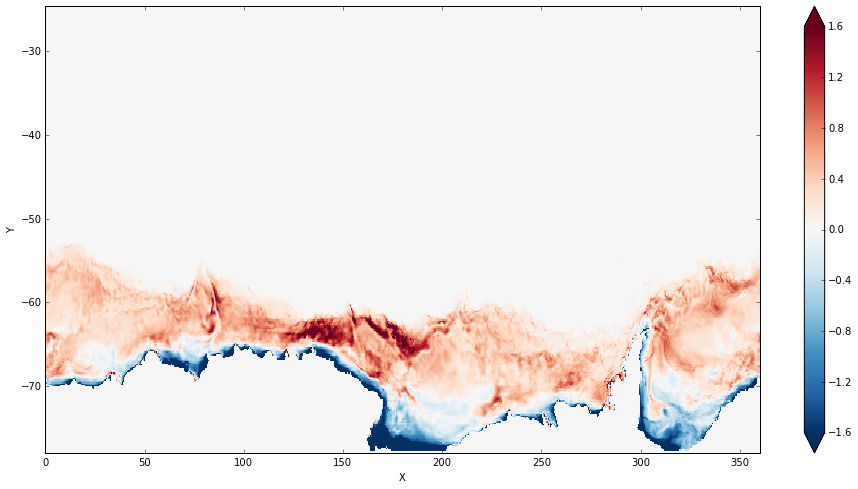

In [66]:
(kg_fw_to_m * year * IO_mean).plot(vmin=-1.6, vmax=1.6)

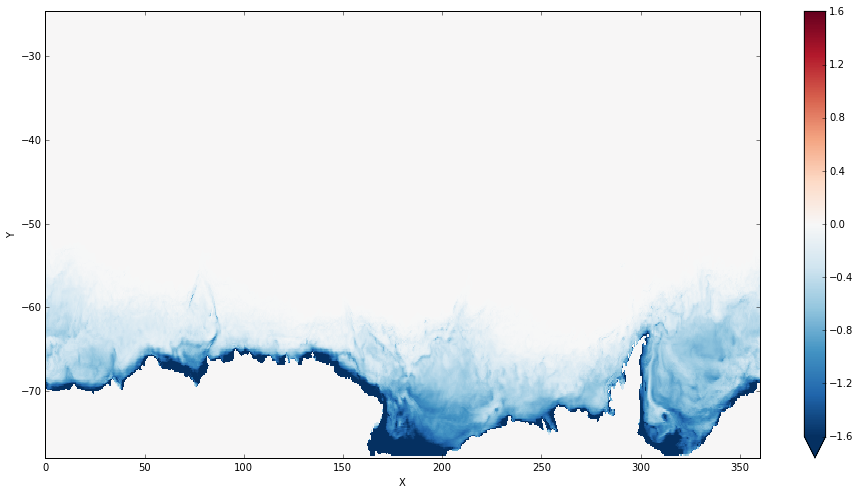

In [67]:
(kg_fw_to_m * year * IO_brine_mean).plot(vmin=-1.6, vmax=1.6)

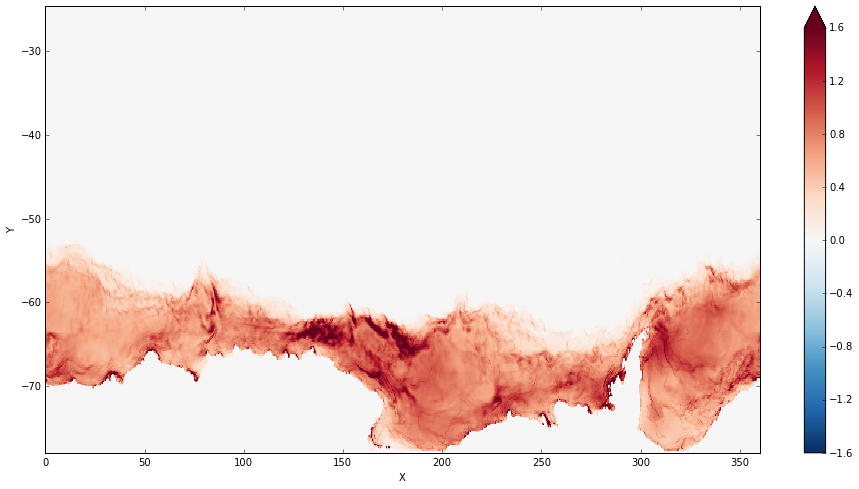

In [68]:
(kg_fw_to_m * year * IO_melt_mean).plot(vmin=-1.6, vmax=1.6)

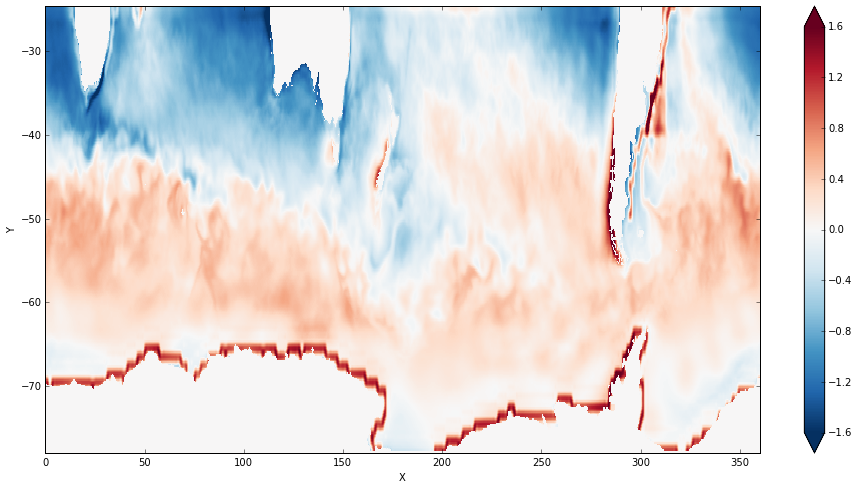

In [71]:
(kg_fw_to_m * year * AO_mean).plot(vmin=-1.6, vmax=1.6)

## data.diagnostics ##

    frequency(1) = 2629200.0,
    fields(1,1) = 'SIarea  ',
                 'SIheff  ',
                 'SIhsnow ',
                 'SItflux ',
                 'SIatmQnt',
                 'SIempmr ',
                 'SIatmFW ',
                 'SIuheff ',
                 'SIvheff ',
                 'TFLUX   ',
                 'SFLUX   ',
                 'THETA   ',
                 'SALT    ',
    levels(1,1) = 1,
    filename(1) = 'DiagIce-monthly',




In [10]:
from mpl_toolkits.basemap import Basemap
def southern_ocean_pcolormesh(lon, lat, data, boundinglat=-55, lw=0.25,
                              ax=None, labels=[1,1,0,1], **kwargs):
    """Plot something in the southern ocean."""
    
    m = Basemap(projection='spstere',boundinglat=boundinglat,lon_0=180, ax=ax)
    #m.drawcoastlines()
    m.fillcontinents(color='0.5',lake_color='0.55')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-80.,81.,20.), linewidth=lw)
    m.drawmeridians(np.arange(-180.,181.,30.), labels=labels, linewidth=lw)
    m.drawmapboundary(fill_color='w')
    #x, y = m(nc.variables['TLON'][:], nc.variables['TLAT'][:])
    return m.pcolormesh(lon, lat, data, latlon=True, **kwargs), m

def southern_ocean_contourf(lon, lat, data, clevs, boundinglat=-55, lw=0.25, 
                            ax=None, labels=[1,1,0,1], **kwargs):
    """Plot something in the southern ocean."""
    
    m = Basemap(projection='spstere',boundinglat=boundinglat,lon_0=180, ax=ax)
    #m.drawcoastlines()
    m.fillcontinents(color='0.5',lake_color='0.55')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-80.,81.,20.), linewidth=lw)
    m.drawmeridians(np.arange(-180.,181.,30.), labels=labels, linewidth=lw)
    m.drawmapboundary(fill_color='w')
    #x, y = m(nc.variables['TLON'][:], nc.variables['TLAT'][:])
    return m.contourf(lon, lat, data, clevs, latlon=True, **kwargs), m



# Full Freshwater Budget #

## from data.diagnostics ##

SIdHbOCN: HEFF rate of change by ocean ice flux

SIdSbOCN: HSNOW rate of change by ocean ice flux

SIdHbATO: HEFF rate of change by open ocn atm flux

/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


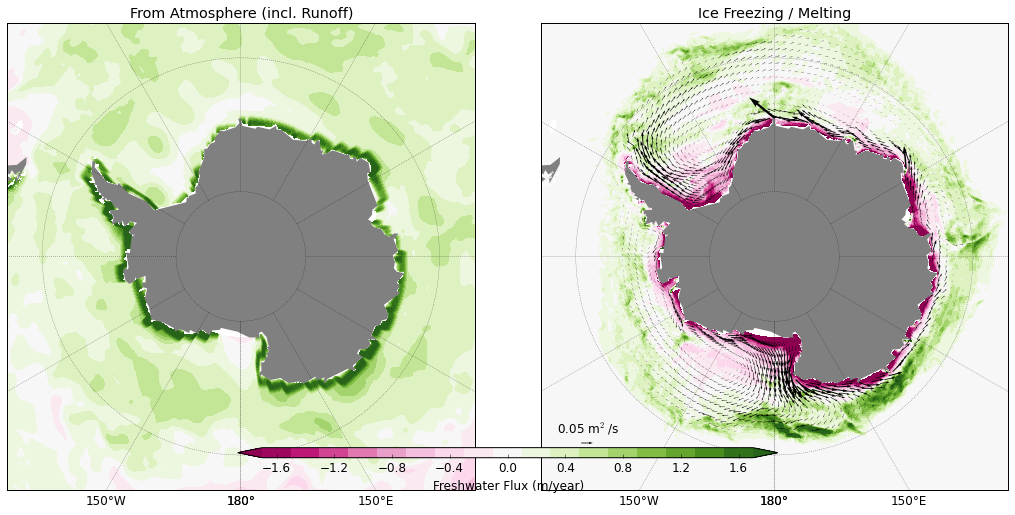

In [18]:
scalefac = 24*60*60*365/1e3
sx,sy = 12,6 # subsample

# annual mean
season = 'ANN'
fld1 = scalefac * np.ma.masked_array(data['SIatmFW'][season], m.mask[0])
fld2 = -scalefac * np.ma.masked_array(data['SIempmr'][season], m.mask[0])
#ice_fw = fld2 - fld1
ice_fw = fld2 - fld1


# UH = m^2 / s
UH, VH = data['SIuheff'][season], data['SIvheff'][season]
mask = np.sqrt(UH**2 + VH**2)<0.005


#plt.rcParams['font.size'] = 8
#fig = plt.figure(figsize=(6.5,4.5))

plt.rcParams['font.size'] = 12
fig = plt.figure(figsize=(15,7))

rholevs = [26.5, 27., 27.2, 27.6, 28.0, 28.2]
clevs = np.arange(-1.8,1.8,0.2)+0.1

ax = fig.add_subplot(121)
pc, bm = southern_ocean_contourf(lon, lat, fld1, clevs, labels=[0,0,0,1],
                               ax=ax, extend='both', cmap='PiYG')
ax.set_title('From Atmosphere (incl. Runoff)')


U = np.ma.masked_array(UH, mask)
V = np.ma.masked_array(VH, mask)
Urot, Vrot = bm.rotate_vector(U, V, lon, lat)
xx, yy = bm(lon, lat)

ax = fig.add_subplot(122)
pc, bm = southern_ocean_contourf(lon, lat, ice_fw, clevs, labels=[0,0,0,1],
                               ax=ax, extend='both', cmap='PiYG')

rho, drhodt, drhods = eos.state_surface(data['THETA'][season], data['SALT'][season])

#con = bm.contour(lon, lat, np.ma.masked_array(rho-1000, m.mask[0]), rholevs,
#           latlon=True, colors='k')
#plt.clabel(con, fmt='%3.1f')

q = bm.quiver(xx[::sy,1::sx], yy[::sy,1::sx], -Urot[::sy,1::sx], -Vrot[::sy,1::sx],
              scale=2, width=0.01, minlength=0.1, minshaft=3)
qk = plt.quiverkey(q, 0.1, 0.1, 0.05, label=r'0.05 m$^2$/s')


#pc.set_clim([-3,3])
ax.set_title('Ice Freezing / Melting')

cax = fig.add_axes([0.25,0.09,0.5,0.02])
cb = plt.colorbar(pc, ticks=np.arange(-1.6,2,0.4), cax=cax, orientation='horizontal')
cb.set_label('Freshwater Flux (m/year)')
plt.tight_layout()
plt.show()
#fig.savefig('../figures_ice_moc/fw_flux.pdf')

In [12]:
UH, VH = ds.SIuheff.mean(dim='time'), ds.SIvheff.mean(dim='time')

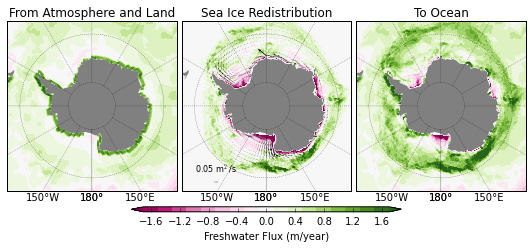

In [42]:
scalefac = 24*60*60*365/1e3
sx,sy = 18,9 # subsample

# annual mean
#season = 'ANN'
#fld1 = scalefac * np.ma.masked_array(data['SIatmFW'][season], m.mask[0])
#fld2 = -scalefac * np.ma.masked_array(data['SIempmr'][season], m.mask[0])
#ice_fw = fld2 - fld1
#ice_fw = fld2 - fld1


# UH = m^2 / s
#mask = np.sqrt(UH**2 + VH**2)<0.005


#plt.rcParams['font.size'] = 8
#fig = plt.figure(figsize=(6.5,3.2))

plt.rcParams['font.size'] = 10
fig = plt.figure(figsize=(7.5,3.5))

rholevs = [26.5, 27., 27.2, 27.6, 28.0, 28.2]
clevs = np.arange(-1.8,1.8,0.2)+0.1

lon, lat = np.meshgrid(ds.X.values, ds.Y.values)

fig.subplots_adjust(left=0.02, right=0.98, bottom=0.2, wspace=0.03)

ax = fig.add_subplot(131)
pc, bm = southern_ocean_contourf(lon, lat, scalefac*AO_mean.values, clevs, labels=[0,0,0,1],
                               ax=ax, extend='both', cmap='PiYG')

ax.set_title('From Atmosphere and Land')

mask = np.sqrt(UH.values**2 + VH.values**2)<0.005
U = np.ma.masked_array(UH.values, mask)
V = np.ma.masked_array(VH.values, mask)
Urot, Vrot = bm.rotate_vector(U, V, lon, lat)
xx, yy = bm(lon, lat)

ax = fig.add_subplot(132)
pc, bm = southern_ocean_contourf(lon, lat, scalefac*IO_minus_AI_mean.values, clevs, labels=[0,0,0,1],
                               ax=ax, extend='both', cmap='PiYG')

q = bm.quiver(xx[::sy,1::sx], yy[::sy,1::sx], -Urot[::sy,1::sx], -Vrot[::sy,1::sx],
              scale=2, width=0.01, minlength=0.1, minshaft=3)
qk = plt.quiverkey(q, 0.2, 0.05, 0.05, label=r'0.05 m$^2$/s',
                    fontproperties={'size': 8})

ax.set_title('Sea Ice Redistribution')


ax = fig.add_subplot(133)
pc, bm = southern_ocean_contourf(lon, lat, scalefac*IO_plus_AO_mean.values, clevs, labels=[0,0,0,1],
                               ax=ax, extend='both', cmap='PiYG')
ax.set_title('To Ocean')


cax = fig.add_axes([0.25,0.13,0.5,0.02])
cb = plt.colorbar(pc, ticks=np.arange(-1.6,2,0.4), cax=cax, orientation='horizontal')
cb.set_label('Freshwater Flux (m/year)')
#plt.tight_layout()
plt.show()
fig.savefig('../figures_ice_moc/fw_flux_new2.pdf')

In [13]:
UH

<xray.DataArray 'SIuheff' (Y: 320, Xp1: 2160)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)
Coordinates:
  * Y        (Y) float32 -77.875 -77.7083 -77.5416 -77.375 -77.2083 -77.0416 ...
  * Xp1      (Xp1) float32 5.55112e-17 0.166667 0.333333 0.5 0.666667 ...